# Imports

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, json
import re, emoji, itertools
from collections import Counter

#drawing wordcloud
from wordcloud import WordCloud,STOPWORDS


from scipy.stats import kstest

In [3]:
DATA_PATH = r"..\data\original\\"
DATA_PATH_LINUX = "../data/original/"

In [4]:
df = pd.read_csv(DATA_PATH_LINUX + r"train.csv")
with open('../notebooks/en_contractions.json') as file:
    contractions = json.load(file)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Preliminary analysis

In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

One fourth of locations are unknown

<AxesSubplot:>

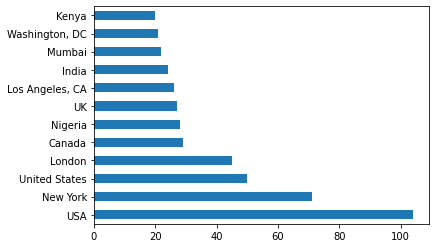

In [6]:
df.location.value_counts()[:12].plot(kind='barh')

By eye we can assume that the most 'disastered' place is USA. The tweets are not divided into only countries or cities (It is hard to perform deeper exploration). There are registered 3341 distinct places.

In [7]:
df.keyword.value_counts()[:14]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
Name: keyword, dtype: int64

/home/rafal/.virtualenvs/hackaton/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

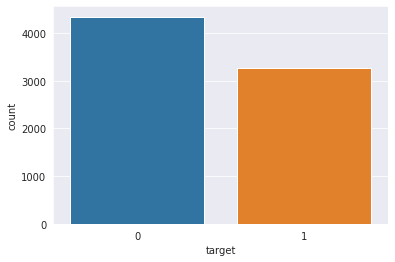

In [8]:
sns.set_style("darkgrid")
sns.countplot(df.target)



Dataset seems almost balanced.

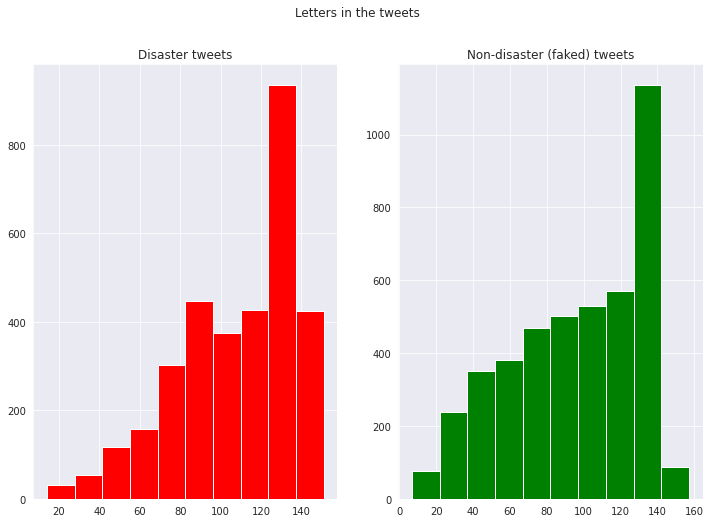

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len_1=df[df['target']==1]['text'].str.len()
ax1.hist(text_len_1,color='red')
ax1.set_title('Disaster tweets')
text_len_2=df[df['target']==0]['text'].str.len()
ax2.hist(text_len_2,color='green')
ax2.set_title('Non-disaster (faked) tweets')
fig.suptitle('Letters in the tweets')
plt.show()



* Kolmogorov–Smirnov test <br>
H0: F1(x)=F2(x) <br>
H1: F1(x)≠F2(x) <br>

In [10]:
kstest(
    text_len_1,
    text_len_2,
    N = 3000)

KstestResult(statistic=0.15774457246877738, pvalue=5.68947250048775e-41)

There is no basis for claiming that the two distributions are the same. By eye we can see that there is more less-lettered tweets in non-disaster group.

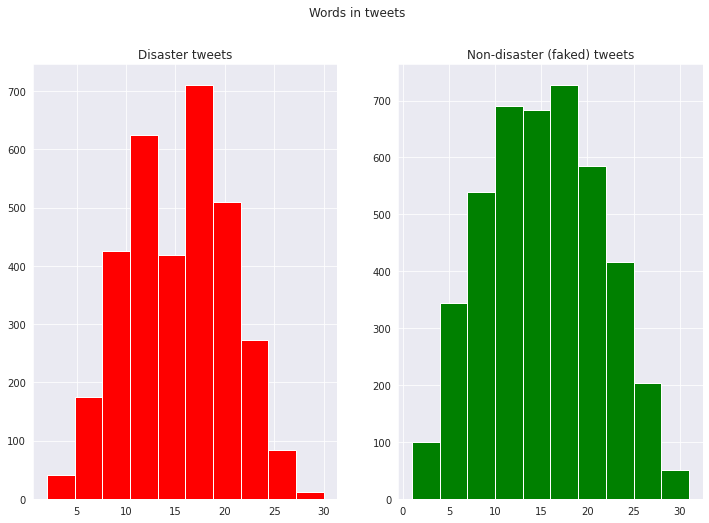

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len_1=df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len_1,color='red')
ax1.set_title('Disaster tweets')
text_len_2=df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len_2,color='green')
ax2.set_title('Non-disaster (faked) tweets')
fig.suptitle('Words in tweets')
plt.show()

* Kolmogorov–Smirnov test <br>
H0: F1(x)=F2(x) <br>
H1: F1(x)≠F2(x) <br>

In [12]:
kstest(
    text_len_1,
    text_len_2,
    N = 3000)

KstestResult(statistic=0.07651667480832142, pvalue=5.982608982918265e-10)

There is no basis for claiming that the two distributions are the same.

## Diving into text column

In [13]:
# A collection of words and punctuation marks to remove from tweets
stop = STOPWORDS
punctuation = list(string.punctuation)
stop.update(punctuation)

In [14]:
def remove_contractions(text):
    """
    Function to replace contractions with their longer forms

    Args:
    string text: text to replace contractions

    Returns:
    string: replaced text
    """
    assert 'contractions' in globals(), "Json file with contractions not loaded"
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

def clean_dataset(text):
    """
    Function to get rif off unwanted patterns
    Args:
    string text: text to clean

    Returns:
    string: replaced text
    """
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 4 or fewer letters
    text = re.sub(r'\b\w{1,4}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [15]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().replace('.',' ').replace(',',' '))
    return " ".join(final_text)

In [16]:
# Remove blank rows if any.
df['text'].dropna(inplace=True)

# Change all the text to lower case.
df['text'] = [entry.lower() for entry in df['text']]


#Clean text
df['text'] =df['text'].apply(clean_dataset)


# Remove contractions
df['text']=df['text'].apply(remove_contractions)

# Remove stopwords
df['text']=df['text'].apply(remove_stopwords)

In [17]:
df['text'].head()

0                deeds reason earthquake allah forgive
1                                  forest ronge canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4            photo alaska smoke wildfires pours school
Name: text, dtype: object

In [18]:
# Function that creates a list of all words in tweets
def get_corpus(text):
    words = []
    for i in text:
        i = str(i)
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
len(corpus)

44263

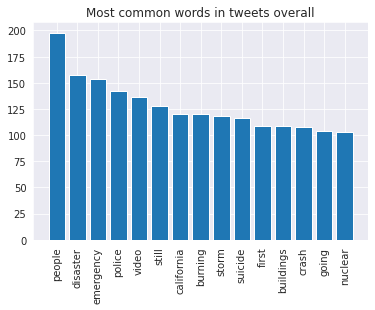

In [19]:
# Word frequency counter in tweets
counter = Counter(corpus)
most_common = counter.most_common(15)
most_common = dict(most_common)



plt.bar(
    most_common.keys(),
    most_common.values()
)
plt.xticks(rotation=90)
plt.title("Most common words in tweets overall")
plt.show()

# Tweets analysis in each label

# Wordclouds

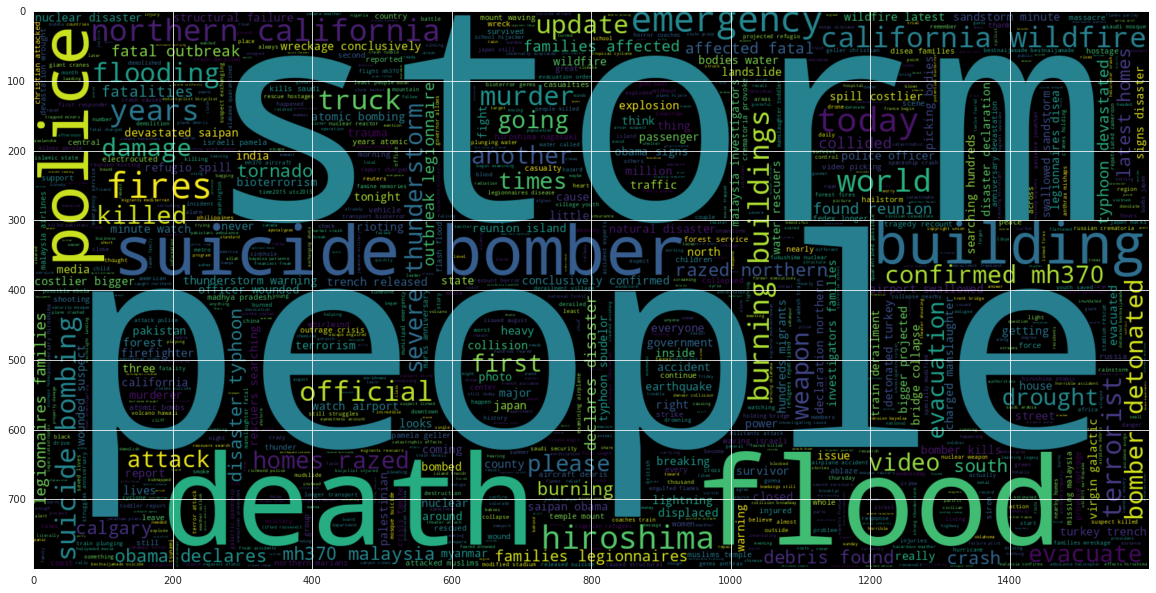

In [20]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 1000,
    width = 1600,
    height = 800,
    stopwords = STOPWORDS
    ).generate(" ".join(df[df.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

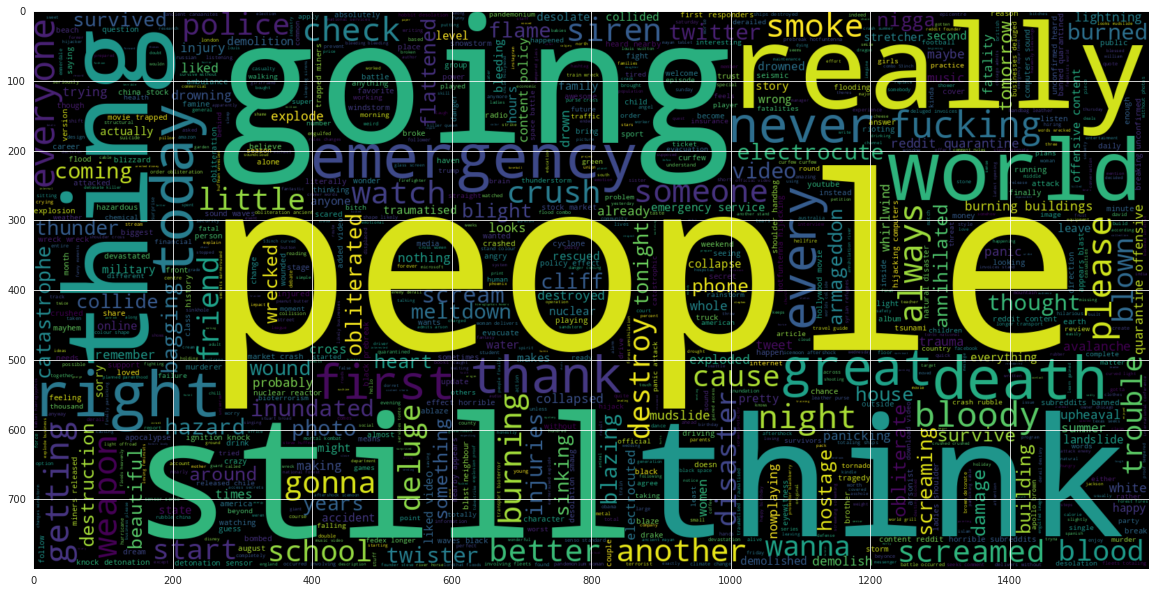

In [21]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 1000,
    width = 1600,
    height = 800,
    stopwords = STOPWORDS
    ).generate(" ".join(df[df.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')